In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import collections
import os
import sys
import random

sys.path.append('../code/')

import routenet_with_link_cap2 as rout


/home/hao/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hao/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hao/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hao/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Second is to load a RouteNet model already trained, for this we need to apply the same 
hyperparamters values used in the training. The following code specifies such 
hyperparameters. 

In [2]:
# hparams = rout.hparams.parse("l2=0.001,dropout_rate=0.5,link_state_dim=32,path_state_dim=32,readout_units=64,learning_rate=0.0001,T=8")
# hparams = rout.hparams.parse("l2=0.1,dropout_rate=0.0,link_state_dim=32,path_state_dim=32,readout_units=256,learning_rate=0.0001,T=4")
hparams = rout.hparams.parse("l2=0.01,dropout_rate=0.0,link_state_dim=64,path_state_dim=64,readout_units=256,learning_rate=0.0001,T=4")

# The following code block loads some functions used to process the datasets:

In [156]:
# path = '/home/hao/backup_thesis/topology/tfrecords/1ms_addlinks_1213_2/'       # nsf add link (12,13)
# path = '/home/hao/backup_thesis/topology/tfrecords/1ms_addlinks_313/'          # nsf add link (3,13)
# path = '/home/hao/backup_thesis/topology/tfrecords/1ms_removelinks_512/'         # nsf remove link (5,12)
# path = '/home/hao/backup_thesis/topology/tfrecords/1ms_removelinks_03/'         # nsf remove link (0,3)
# path = '/home/hao/backup_thesis/topology/tfrecords/1ms_removelinks_109/'        # nsf remove link (10,9)
# path = '/home/hao/backup_thesis/topology/tfrecords/Result_Test_gbn/addlink57/'        # gbn add link (5,7)
# path = '/home/hao/backup_thesis/topology/tfrecords/Result_Test_gbn/dellink1516/'        # gbn add link (7,16)
# path = '/home/hao/backup_thesis/topology/tfrecords/new_result_test/100ms/'      # NSF 5,10,50,100
# path = '/home/hao/backup_thesis/topology/tfrecords/Result_Test_gbn/SP/5ms/'      # GBN 5,10,50,100
# path = '/home/hao/backup_thesis/topology/tfrecords/test_data_per_200/'              # NSF 1ms 
# path = '/home/hao/backup_thesis/topology/tfrecords/Eval_pkt_delay/'
# path = '/home/hao/backup_thesis/topology/tfrecords/eval0517_norm/'
# path = '/home/hao/backup_thesis/topology/tfrecords/test_changepath0807_8000/'
# path = '/home/hao/backup_thesis/topology/tfrecords/Changepath/50ms/'
# path = '/home/hao/backup_thesis/topology/tfrecords/1ms_removelinks/'
# path = '/home/hao/backup_thesis/topology/tfrecords/test_2ms/'                     # NSF 2ms 
# path = '/home/hao/backup_thesis/topology/tfrecords/test_gbn_per_200_1000/'
# path = '/home/hao/backup_thesis/topology/tfrecords/test_gbn_per_200_1KB_2ms/'         # GBN 2ms c350
# path = '/home/hao/backup_thesis/topology/tfrecords/test_gbn_per_200_1KB_1ms_c350/'  # GBN 1ms c350
# path = '/home/hao/backup_thesis/topology/tfrecords/nsf_1KB_1ms_add_node/'
# path = '/home/hao/backup_thesis/topology/tfrecords/gbn_del_node_16/'
filename = random.choice(os.listdir(path))
sample_file = path + filename
# sample_file = path + '30.tfrecords'
print(sample_file)

/home/hao/backup_thesis/topology/tfrecords/test_data_per_200/2908.tfrecords


In [157]:
def parse(serialized, target='delay'):
    '''
    Target is the name of predicted variable
    '''
    with tf.device("/cpu:0"):
        with tf.name_scope('parse'):
            features = tf.parse_single_example(
                serialized,
                features={
                    'traffic':tf.VarLenFeature(tf.float32),
                    target:tf.VarLenFeature(tf.float32),
                    'link_capacity': tf.VarLenFeature(tf.float32),
                    'links':tf.VarLenFeature(tf.int64),
                    'paths':tf.VarLenFeature(tf.int64),
                    'sequences':tf.VarLenFeature(tf.int64),
                    'n_links':tf.FixedLenFeature([],tf.int64),
                    'n_paths':tf.FixedLenFeature([],tf.int64),
                    'n_total':tf.FixedLenFeature([],tf.int64)
                })
            for k in ['traffic',target,'link_capacity','links','paths','sequences']:
                features[k] = tf.sparse_tensor_to_dense(features[k])
                # if k == 'traffic':
                #     features[k] = (features[k] - 0.17) / 0.13
                #     # tf.print('traffic len = ', features[k])
                # if k == 'link_capacity':
                #     features[k] = (features[k] - 25.0) / 40.0
    # for k,v in features.items():
    #     if k is not target:
    #         print({k:v})
    return {k:v for k,v in features.items() if k is not target },features[target]

def read_dataset():
    ds = tf.data.TFRecordDataset(sample_file)
    # ds = tf.data.TFRecordDataset('test.tfrecord')
    # We parse the serialized input from the file
    ds = ds.map(lambda buf: parse(buf))

    ds = ds.batch(1)

    it = ds.make_initializable_iterator()
    # print(it)
    return it

# Delay prediction with RouteNet


Then,   we   load   the   model   provided   in   our   GitHub   repository   to   produce   delay predictions. For the predictions, we use the first sample from the file selected above:

In [158]:
import csv 
def _int64_feature(value):
    return tf.compat.v1.train.Feature(int64_list=tf.compat.v1.train.Int64List(value=[value]))

def _int64_features(value):
    return tf.compat.v1.train.Feature(int64_list=tf.compat.v1.train.Int64List(value=value))


def _float_features(value):
    return tf.compat.v1.train.Feature(float_list=tf.compat.v1.train.FloatList(value=value))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

graphPredict = tf.Graph()
with graphPredict.as_default():
    model = rout.ComnetModel(hparams)
    model.build()
    # model.summary()
    it = read_dataset()
    features, label = it.get_next()

    with tf.name_scope('predict'):
        predictions = tf.map_fn(lambda x: model(x, training=False), features, dtype=tf.float32)

    preds = tf.squeeze(predictions)
    # predictions = 0.54*preds + 0.37
    predictions = preds



In [159]:
with tf.compat.v1.Session(graph=graphPredict) as sess:
    sess.run(tf.compat.v1.local_variables_initializer())
    sess.run(tf.compat.v1.global_variables_initializer())
    saver = tf.compat.v1.train.Saver()
    # path to the checkpoint we want to restore
    # saver.restore(sess, './0605/0605/model.ckpt-18335')
    # saver.restore(sess, './0709_norm2/model.ckpt-100000')
    # saver.restore(sess,'./0726_changepath5841/model.ckpt-76630')
    # saver.restore(sess,'./0805_changepath4000_batch16/model.ckpt-221982')
    # saver.restore(sess,'./0807_changepath8000_batch16/model.ckpt-77297')
    # saver.restore(sess,'./gbn_model/model.ckpt-100000')
    # saver.restore(sess,'./gbn_model_c500/model.ckpt-47670')
    # saver.restore(sess,'./gbn_model_c250_6230/model.ckpt-100000')
    # saver.restore(sess,'./nsf__data_per_200/model.ckpt-100000')
    # saver.restore(sess,'./nsf_2ms_200/model.ckpt-100000')
    # saver.restore(sess,'./gbn_1ms_800/model.ckpt-31052')
    # saver.restore(sess,'./gbn_1ms_1000_1400B/model.ckpt-98390')
    # saver.restore(sess,'./gbn_per_200_1000_2KB/model.ckpt-106506')
    # saver.restore(sess,'./gbn_per_200_1000_2KB_2/model.ckpt-11745')
    # saver.restore(sess,'./gbn_per_200_1KB_2ms/model.ckpt-13174')
    # saver.restore(sess,'./nsf_200_200/model.ckpt-91997')
    # saver.restore(sess,'./gbn_per_200_1KB_1ms_c350/model.ckpt-60778')
    saver.restore(sess,'./mix_nsf1ms_gbn_1ms350/model.ckpt-100714')   # NSF+GBN model
    hats = []

    for i in range(50):
        sess.run(it.initializer)
        pred_Delay, label_Delay = sess.run([predictions, label])
        hats.append(pred_Delay)
   
    print(pred_Delay.shape,label_Delay.shape)
    final_prediction = np.median(hats, axis=0)
    print(final_prediction)

    with open('prediction', 'w' ) as csvfile:
        writer = csv.writer(csvfile)
        for p in list(final_prediction):
            writer.writerow([p])


INFO:tensorflow:Restoring parameters from ./mix_nsf1ms_gbn_1ms350/model.ckpt-100714
(182,) (1, 182)
[ 1.96383438e+01  6.22935547e+02  8.04351521e+00  9.79306259e+01
  1.14907434e+03 -1.65263665e+00  1.16716870e+03  1.18423596e+03
  9.22160767e+02  1.34481087e+01 -1.27876437e+00  9.19306519e+02
  1.15618030e+03 -4.04146385e+00  2.12135880e+02  1.09177234e+03
  2.17915359e+02  1.57871338e+03  1.09439697e+03  1.55796521e+03
  1.61701086e+03  2.17014122e+01  1.09425500e+03  2.15677933e+02
  1.14541565e+03  1.09861926e+03  1.61717444e+03 -4.07888699e+00
  1.57635901e+03  1.15080176e+03  1.05553333e+03  1.58298877e+03
  5.46150684e+00  1.06157605e+03  1.17538977e+03  1.15157410e+03
  1.15199084e+03  6.34401489e+02  1.88988457e+01  2.30444813e+01
  2.08251801e+01  1.15927649e+03  1.03226463e+02  1.61343103e+03
  1.42158575e+01  1.04429329e+02  2.02731395e+00  9.15898323e-01
  9.20601379e+02  1.03200676e+02  1.61945203e+03  1.68011189e+01
  1.61610803e+03  2.21221085e+02  1.61342517e+03  6.250

# Plot Result

In [160]:
num_paths = len(final_prediction) # Set how many paths you want to visualize
ids = random.sample(range(0, len(final_prediction)), num_paths)
ids.sort()
sample_prediction = []
sample_label = []
for i in ids:
    sample_prediction.append(final_prediction[i])
    # print('pred = ',final_prediction[i])
    sample_label.append(label_Delay[0][i])

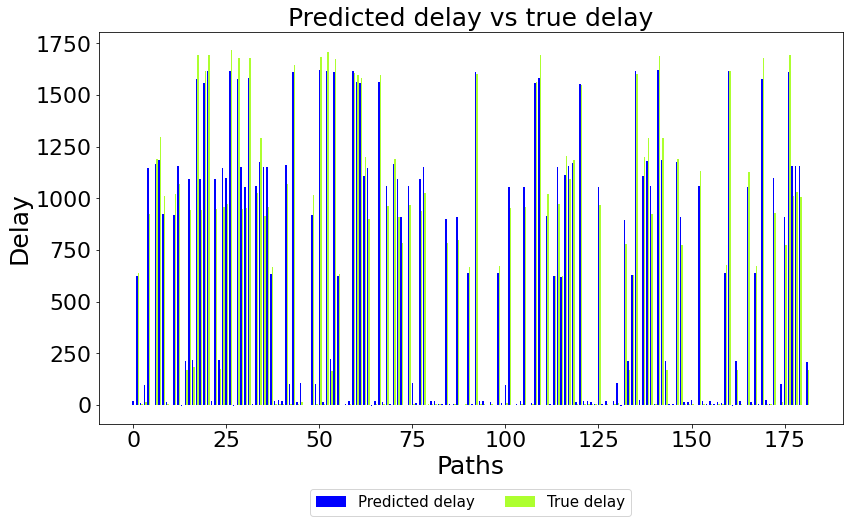

In [161]:
# create plot
fig, ax = plt.subplots()
index = np.arange(num_paths)
bar_width = 0.40

rects1 = plt.bar(index, sample_prediction, bar_width,
color='b',
label='Predicted delay')

rects2 = plt.bar(index + bar_width, sample_label, bar_width,
color='greenyellow',
label='True delay')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)

plt.xlabel('Paths',fontsize=25)
plt.ylabel('Delay',fontsize=25)
plt.title('Predicted delay vs true delay',fontsize=25)
plt.legend(loc='center',fontsize=15,bbox_to_anchor=(0.5, -0.2),fancybox=True,ncol=2)
plt.tight_layout()

fig = plt.gcf()
fig.set_size_inches(14, 8.5)

# Performance metric

In [163]:
from scipy.stats import spearmanr
# Mean Square Error
mse = np.square(np.asarray(sample_label)-np.asarray(sample_prediction)).mean()
mre = np.mean(np.asarray(sample_label)-np.asarray(sample_prediction)/np.asarray(sample_label))

mre_tmp = []
label_tmp = []
mre_list = []
tot = 0
res = 0
m = np.mean(sample_label)
for i in range(len(sample_label)):
    # if sample_prediction[i] > 0:
    mre_tmp.append(sample_prediction[i])
    label_tmp.append(sample_label[i])
    tot += pow(sample_label[i] - m,2)
    res += pow(sample_label[i] - sample_prediction[i],2)

coef, p = spearmanr(sample_label,sample_prediction)


mae = 0
mse = 0
for i in range(len(mre_tmp)):
    
    if label_tmp[i] > 0:
        mre_list.append(abs((label_tmp[i]-mre_tmp[i])) / label_tmp[i])
    mae += abs(label_tmp[i] - mre_tmp[i])
    mse += pow((mre_tmp[i]-label_tmp[i]),2)

sorted_label_tmp = sorted(label_tmp)
sorted_mre_tmp = sorted(mre_tmp)
rank_label_tmp = [sorted_label_tmp.index(i) for i in label_tmp]
rank_mre_tmp = [sorted_mre_tmp.index(i) for i in mre_tmp]
print('pred, label = \n',mre_tmp[i],label_tmp[i]) # Show predcit & label value
print('rho = ',coef)    
print("MAPE = " ,np.mean(mre_list))
print("R-squared = " , 1-(res/tot))
p_diff = 0
for i in range(len(mre_tmp)):
    p_diff += abs(rank_label_tmp[i] - rank_mre_tmp[i])
    print('rank = ')
    print(rank_label_tmp[i] , rank_mre_tmp[i])


rho =  0.9630566680776423
19.638344 2.011
622.93555 638.194
8.043515 2.971
97.930626 12.474
1149.0743 926.117
-1.6526366 0.111
1167.1687 1190.957
1184.236 1297.817
922.16077 1009.804
13.448109 3.461
-1.2787644 2.277
919.3065 1018.853
1156.1803 1071.197
-4.041464 0.343
212.13588 167.864
1091.7723 943.129
217.91536 183.327
1578.7134 1693.074
1094.397 943.978
1557.9652 1614.271
1617.0109 1696.131
21.701412 2.414
1094.255 947.365
215.67793 176.601
1145.4156 960.31
1098.6193 973.986
1617.1744 1718.7
-4.078887 0.208
1576.359 1681.513
1150.8018 949.167
1055.5333 954.923
1582.9888 1677.898
5.461507 2.436
1061.576 1026.364
1175.3898 1290.788
1151.5741 916.979
1151.9908 956.007
634.4015 667.126
18.898846 5.562
23.044481 3.411
20.82518 3.637
1159.2765 1068.309
103.22646 5.698
1613.431 1644.247
14.2158575 4.817
104.42933 13.473
2.027314 0.07
0.9158983 0.082
920.6014 1016.07
103.200676 7.081
1619.452 1685.787
16.801119 4.824
1616.108 1710.327
221.22108 164.347
1613.4252 1674.19
625.024 632.478
2.16

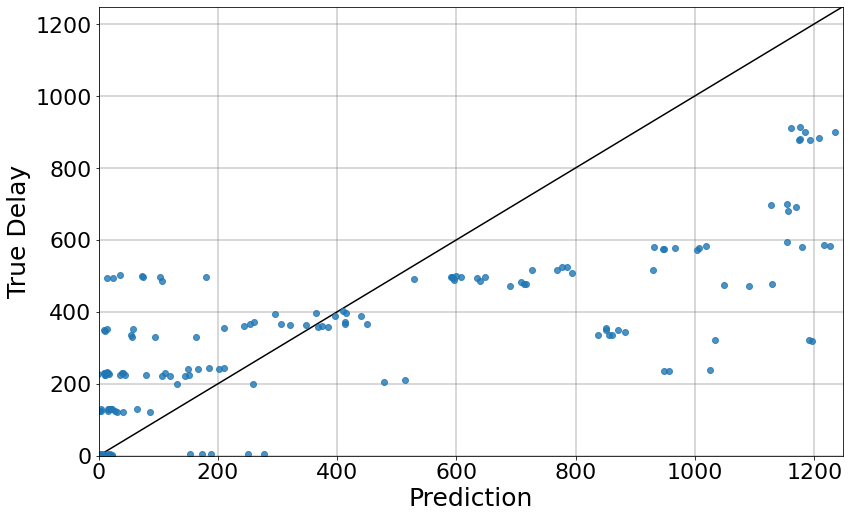

In [393]:
ax = plt.subplot()

xerr = [final_prediction - np.percentile(hats, q=5, axis=0),
        np.percentile(hats, q=95, axis=0) - final_prediction]

ax.errorbar(x=final_prediction, y=label_Delay[0], fmt='o', xerr=xerr, alpha=0.8, ecolor='silver')

m = max(label_Delay[0])
ax.plot([0, 1.3 * m], [0, 1.3 * m], 'k')
ax.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
ax.set_xlabel('Prediction', fontsize=25)
ax.set_ylabel('True Delay', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
ax.set_xlim(left=-0.002, right=1.2 * m)
ax.set_ylim(bottom=-0.005, top=1.2 * m)
fig = plt.gcf()
plt.tight_layout()
fig.set_size_inches(14, 8.5)

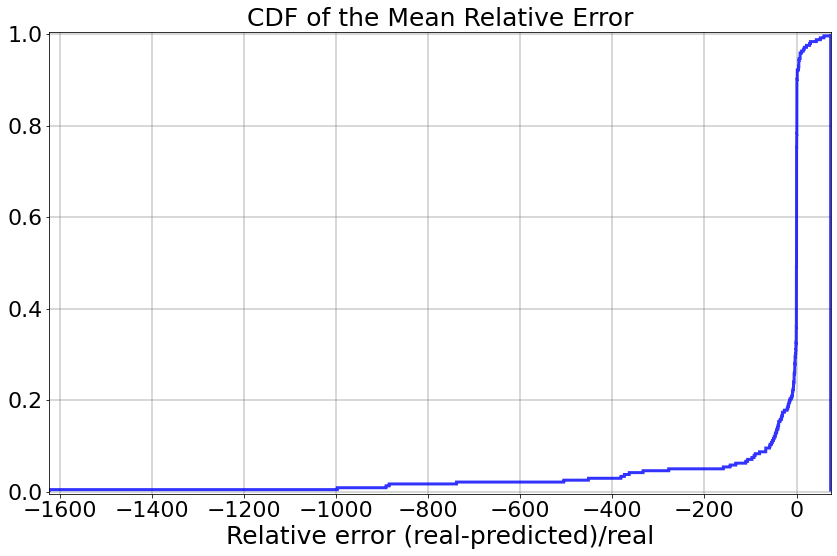

In [281]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

mre = (label_Delay-final_prediction)/label_Delay
mre = np.sort(mre)

mre = np.insert(mre, 0, -15.0)
mre = np.append(mre, 15.0)

plt.hist(mre, cumulative=True, histtype='step', bins=10000, alpha=0.8, color='blue', density=True, linewidth=3)
plt.ylim((-0.005, 1.005))
plt.xlim((mre[1], mre[-2]))  
plt.xlabel("Relative error (real-predicted)/real", fontsize=25)
plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.3)
plt.title('CDF of the Mean Relative Error',fontsize=25)
fig = plt.gcf()
fig.set_size_inches(14, 8.5)